## Stock Price Prediction
Here, we will predict stock prices for the next day, based on the time series patterns observed for the previous days.

## Load & Split Stock Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

#Load the Meta stock price data from CSV
prices = pd.read_csv('FB-stock-prices.csv')

#Review loaded data
print(prices.dtypes)
prices.head()

Date     object
Price     int64
dtype: object


,Date,Price
0,1/4/2021,269
1,1/5/2021,271
2,1/6/2021,263
3,1/7/2021,269
4,1/8/2021,268


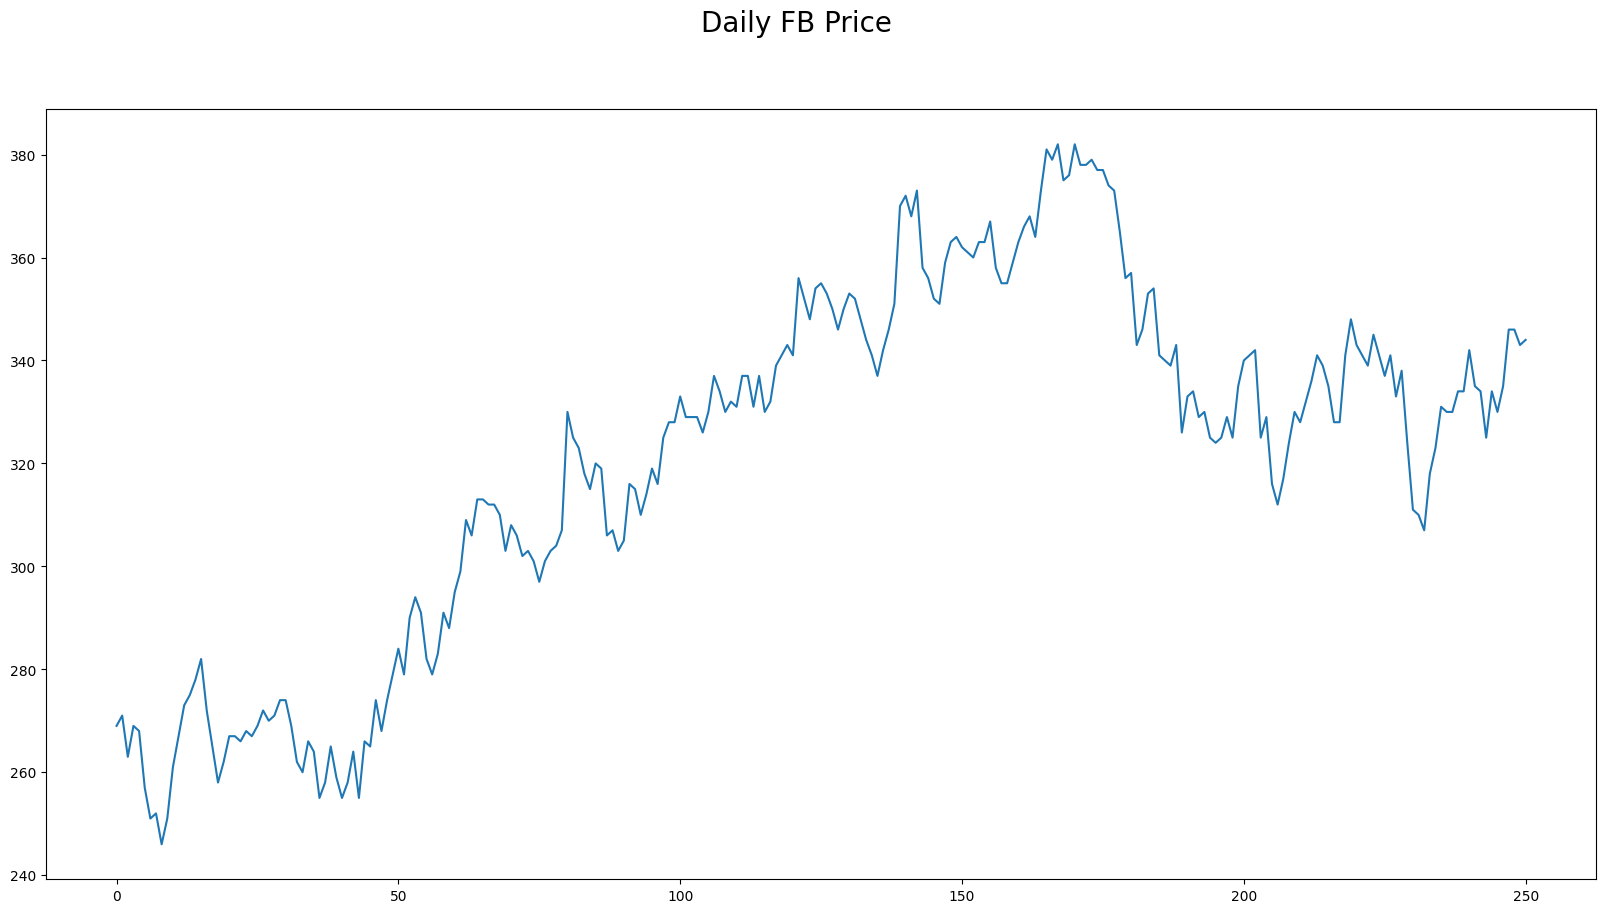

In [2]:
# Plot the data to visualize the stock price

plt.figure(figsize=(20,10)).suptitle("Daily FB Price", fontsize=20)
plt.plot(prices["Price"])
plt.show()

### Split Data

In [3]:
from sklearn.preprocessing import StandardScaler

# Scale the Data
scaler = StandardScaler()
scaled_prices=scaler.fit_transform(prices[["Price"]].values)

#Split data into Training and Test sets
total_size = len(scaled_prices)

#Test dataset size
test_size = 50

#Training dataset size
train_size = total_size - test_size
print(train_size, test_size)

training_prices = scaled_prices[0:train_size,:]
test_prices = scaled_prices[train_size:,:]

print(training_prices.shape, test_prices.shape)

201 50
(201, 1) (50, 1)


## Create Dataset for RNN

In [4]:
#Prepare RNN Dataset. 
#Each data point (X) is linked to the previous data points of size=lookback
#The predicted value (Y) is the next point

def create_rnn_dataset(data, lookback=1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

#lookback for 25 previous days
lookback=25

#Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(training_prices,lookback)

#Reshape for use with RNN
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (175, 1, 25) (175,)


## Build the RNN Model

In [5]:
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense
import tensorflow as tf

tf.random.set_seed(3)

#Create a Keras Model
price_model=Sequential()
#Add Simple RNN layer with 32 nodes
price_model.add(SimpleRNN(32, input_shape=(1,lookback)))
#Add a Dense layer at the end for output
price_model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
price_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
price_model.summary()

#Train the model
price_model.fit(train_req_x, train_req_y, 
             epochs=5, batch_size=1, verbose=1)

c:\Users\rages\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,889 (7.38 KB)

 Trainable params: 1,889 (7.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1682 - mse: 0.1682
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0622 - mse: 0.0622
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0483 - mse: 0.0483
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0412 - mse: 0.0412   
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365 - mse: 0.0365 


## Test the Model

In [9]:
#Preprocess the test dataset, the same way training set is processed
test_req_x, test_req_y = create_rnn_dataset(test_prices,lookback)

print(test_req_x.shape, test_req_y.shape)

test_req_x = np.reshape(test_req_x, 
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

#Evaluate the model
price_model.evaluate(test_req_x, test_req_y, verbose=1)

#Predict on the test dataset
predict_on_test = price_model.predict(test_req_x)

#Inverse the scaling to view results
predict_on_test = scaler.inverse_transform(predict_on_test)

(24, 25) (24,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0579 - mse: 0.0579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


## Visualize the Results

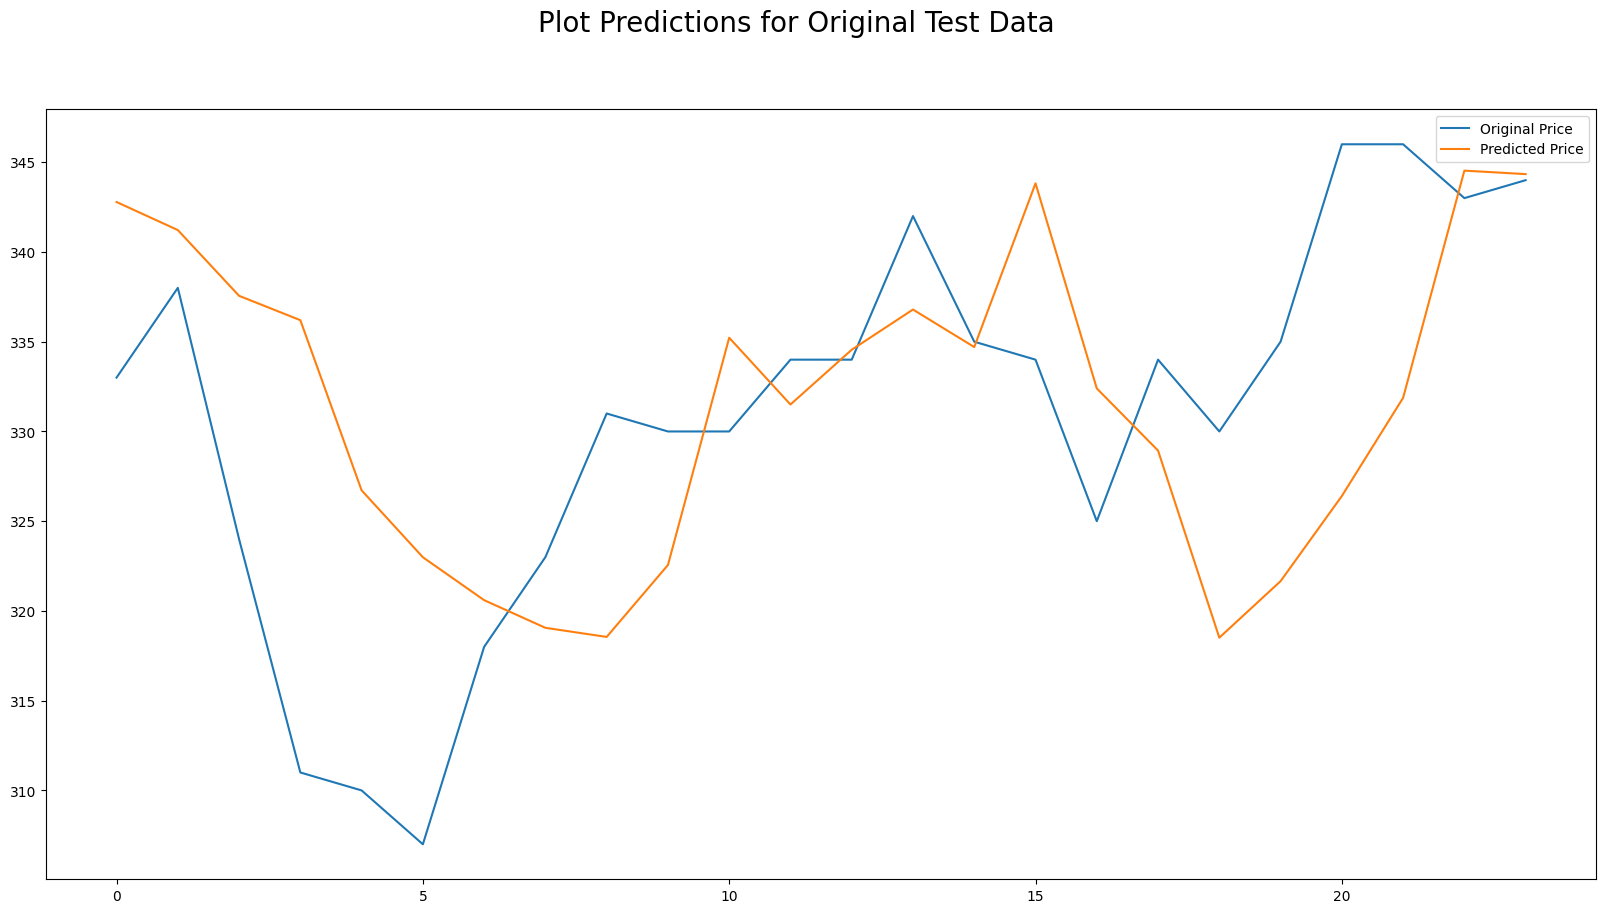

In [10]:
#Extract original test values that map to the same dates on the predicted test values
orig_test_values = prices[["Price"]].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original Test Data", fontsize=20)
plt.plot(orig_test_values, label="Original Price")
plt.plot(predict_on_test, label="Predicted Price")
plt.legend()
plt.show()

Accuracy can be increased by having more data points, creating more lookback and trying other RNN models

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Function to calculate MAPE and accuracy in percentage
def calculate_mape(true_values, predicted_values):
    # Calculate MAPE
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    # Calculate accuracy
    accuracy = 100 - mape
    # Print the results
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    print(f"Accuracy: {accuracy}%")
    return mape, accuracy

# Make predictions on the test dataset
predict_on_test_rnn = price_model.predict(test_req_x)

# Inverse the scaling to get original values
predict_on_test_rnn = scaler.inverse_transform(predict_on_test_rnn)

# Get the true values in the original scale
true_values = scaler.inverse_transform(test_req_y.reshape(-1, 1))

# Calculate the MAPE and accuracy for the test data
calculate_mape(true_values, predict_on_test_rnn)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Mean Absolute Percentage Error (MAPE): 2.0395319692061293%
Accuracy: 97.96046803079388%


(2.0395319692061293, 97.96046803079388)

### Predictions

In [8]:
#Previous prices
previous_prices = np.array([325,335,340,341,342,
                            325,329,316,312,317,
                            324,330,328,332,336,
                            341,339,335,328,328,
                            341,348,343,341,339])

#Scale
scaled_prices = scaler.transform(previous_prices.reshape(-1, 1))
#Reshape
model_input = np.reshape(scaled_prices, 
                         (scaled_prices.shape[1],1, scaled_prices.shape[0]))

#predictions
prediction = price_model.predict(model_input)

#scale back
norm_prediction = scaler.inverse_transform(prediction)

print("The predicted Stock price is :", norm_prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
The predicted Stock price is : 337.88293
